In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "../input/data/"

tsla_data = pd.read_csv(DATA_PATH + "TSLA.csv", sep=",")
tsla_ts = tsla_data[["Date", "Close"]].copy()
tsla_ts.columns = ["x", "y(x)"]
tsla_ts["x"] = pd.to_datetime(tsla_ts["x"])
tsla_ts.head(2)

,x,y(x)
0,2020-10-01,149.386673
1,2020-10-02,138.363327


# Discretization

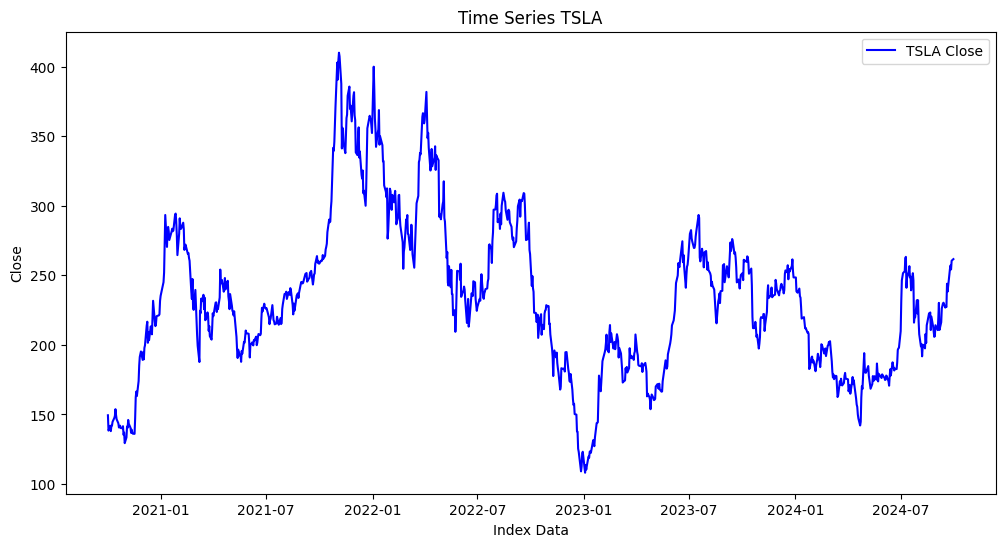

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(tsla_ts["x"], tsla_ts["y(x)"], label="TSLA Close", color="blue")
plt.xlabel("Index Data")
plt.ylabel("Close")
plt.title("Time Series TSLA")
plt.legend()
plt.show()


In [3]:
from sklearn.preprocessing import KBinsDiscretizer

# Intanciando a classe para discretizar utilizando os quartil
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

tsla_ts['discretized'] = discretizer.fit_transform(tsla_ts['y(x)'].to_numpy().reshape(-1, 1))

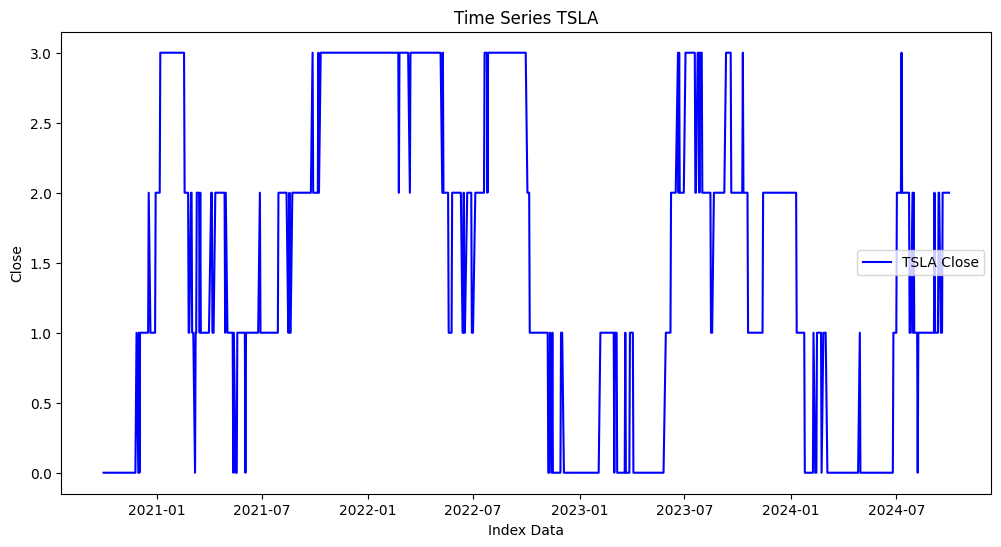

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(tsla_ts["x"], tsla_ts['discretized'], label="TSLA Close", color="blue")
plt.xlabel("Index Data")
plt.ylabel("Close")
plt.title("Time Series TSLA")
plt.legend()
plt.show()

In [11]:
df = pd.DataFrame({'Value_t': tsla_ts['discretized'], 
                   'Value_t1': tsla_ts['discretized'].shift(-1)}).dropna()

# State counts

Para entender os dados fornecidos, podemos começar contando com que frequência cada estado da variável ocorre. Se a variável depender dos pais, as contagens serão feitas condicionalmente nos estados dos pais, ou seja, separadamente para cada configuração pai:

In [13]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator

model = BayesianNetwork([('Value_t', 'Value_t1')])
pe = ParameterEstimator(model, df)

for node in model.nodes():
    print(f"Parâmetros de {node}:\n", pe.state_counts(node))

Parâmetros de Value_t:
          count
Value_t       
0.0        251
1.0        251
2.0        250
3.0        252
Parâmetros de Value_t1:
 Value_t     0.0    1.0    2.0    3.0
Value_t1                            
0.0       230.0   20.0    0.0    0.0
1.0        21.0  206.0   24.0    0.0
2.0         0.0   25.0  209.0   17.0
3.0         0.0    0.0   17.0  235.0


# Maximum Likelihood Estimation

Esta abordagem é a Estimativa de Máxima Verossimilhança (MLE). De acordo com o MLE, devemos preencher os CPDs de tal forma que P(`data`|`model`) seja máximo. Isto é conseguido ao usar as frequências relativas. Consulte [1], seção 17.1 para uma introdução à estimativa de parâmetros de ML. pgmpy suporta MLE da seguinte forma:

In [18]:
from pgmpy.estimators import MaximumLikelihoodEstimator

mle = MaximumLikelihoodEstimator(model, df)

print(mle.estimate_cpd('Value_t'))
print(mle.estimate_cpd('Value_t1'))

+--------------+----------+
| Value_t(0.0) | 0.25     |
+--------------+----------+
| Value_t(1.0) | 0.25     |
+--------------+----------+
| Value_t(2.0) | 0.249004 |
+--------------+----------+
| Value_t(3.0) | 0.250996 |
+--------------+----------+
+---------------+-----+---------------------+
| Value_t       | ... | Value_t(3.0)        |
+---------------+-----+---------------------+
| Value_t1(0.0) | ... | 0.0                 |
+---------------+-----+---------------------+
| Value_t1(1.0) | ... | 0.0                 |
+---------------+-----+---------------------+
| Value_t1(2.0) | ... | 0.06746031746031746 |
+---------------+-----+---------------------+
| Value_t1(3.0) | ... | 0.9325396825396826  |
+---------------+-----+---------------------+


In [28]:
model.fit(df, estimator=MaximumLikelihoodEstimator)
# Obtendo a CPD do nó 'Value_t1'
cpd_value_t = model.get_cpds('Value_t')

# Imprimindo a tabela completa de CPD
print(cpd_value_t)


+--------------+----------+
| Value_t(0.0) | 0.25     |
+--------------+----------+
| Value_t(1.0) | 0.25     |
+--------------+----------+
| Value_t(2.0) | 0.249004 |
+--------------+----------+
| Value_t(3.0) | 0.250996 |
+--------------+----------+
